<a href="https://colab.research.google.com/github/lustraka/Data_Analysis_Workouts/blob/main/Communicate_Data_Findings/Part_I_exploration_ames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis of House Prices in Ames, Iowa - Part I
## by Lubomir Straka

## Introduction
> Introduce the dataset


This project processes a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The [Ames Housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) was downloaded from Kaggle.com and is hosted on this project's GitHub repository to avoid the need of working with the Kaggle's API.

>**Rubric Tip**: Your code should not generate any errors, and should use functions, loops where possible to reduce repetitive code. Prefer to use functions to reuse code statements.

> **Rubric Tip**: Document your approach and findings in markdown cells. Use comments and docstrings in code cells to document the code functionality.

>**Rubric Tip**: Markup cells should have headers and text that organize your thoughts, findings, and what you plan on investigating next.  



## Preliminary Wrangling


In [1]:
# Import all packages and set plots to be embedded inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

> Load in your dataset and describe its properties through the questions below. Try and motivate your exploration goals through this section.


In [2]:
# Load the Ames Housing dataset
path = 'https://raw.githubusercontent.com/lustraka/Data_Analysis_Workouts/main/Communicate_Data_Findings/ames_train_data.csv'
ames = pd.read_csv(path, index_col='Id')
print(ames.shape)

(1460, 80)


In [3]:
################
# Wrangle data #
################
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The categorical features nominative (unordered)
catn = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig",
        "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
        "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
        "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
        "SaleType", "SaleCondition"]


# The categorical features ordinal (ordered) 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

cato = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
cato = {key: ["None"] + value for key, value in
                  cato.items()}


def encode_dtypes(df):
    """Encode nominal and ordinal categorical variables."""

    global catn, cato

    # Nominal categories
    for name in catn:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in cato.items():
        df[name] = df[name].astype(pd.CategoricalDtype(levels,
                                                    ordered=True))
    return df

def impute_missing(df):
    """Impute zeros to numerical and None to categorical variables."""

    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

def clean_data(df):
    """Remedy typos and mistakes based on EDA."""

    global cato
    # YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
    df.YearRemodAdd = np.where(df.YearRemodAdd < df.YearBuilt, df.YearBuilt, df.YearRemodAdd)
    assert len(df.loc[df.YearRemodAdd < df.YearBuilt]) == 0, 'Check YearRemodAdd - should be greater or equal then YearBuilt'
    
    # Check range of years
    yr_max = 2022
    # Some values of GarageYrBlt are corrupt. Fix them by replacing them with the YearBuilt
    df.GarageYrBlt = np.where(df.GarageYrBlt > yr_max, df.YearBuilt, df.GarageYrBlt)
    assert df.YearBuilt.max() < yr_max and df.YearBuilt.min() > 1800, 'Check YearBuilt min() and max()'
    assert df.YearRemodAdd.max() < yr_max and df.YearRemodAdd.min() > 1900, 'Check YearRemodAdd min() and max()'
    assert df.YrSold.max() < yr_max and df.YrSold.min() > 2000, 'Check YrSold min() and max()'
    assert df.GarageYrBlt.max() < yr_max and df.GarageYrBlt.min() >= 0, 'Check GarageYrBlt min() and max()'
    
    # Check values of ordinal catagorical variables
    for k in cato.keys():
      assert set(df[k].unique()).difference(df[k].cat.categories) == set(), f'Check values of {k}'
    
    # Check typos in nominal categorical variables
    df['Exterior2nd'] = df['Exterior2nd'].replace({'Brk Cmn':'BrkComm', 'CmentBd':'CemntBd', 'Wd Shng':'WdShing'})
    # Renew a data type after replacement
    df['Exterior2nd'] = df['Exterior2nd'].astype("category")
    if "None" not in df['Exterior2nd'].cat.categories:
        df['Exterior2nd'].cat.add_categories("None", inplace=True)

    return df

def label_encode(df):
    """Encode categorical variables using their dtype setting."""

    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

# Pre-process data
ames = encode_dtypes(ames)
ames = impute_missing(ames)
ames = clean_data(ames)

ames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   category
 2   LotFrontage    1460 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   category
 5   Alley          1460 non-null   category
 6   LotShape       1460 non-null   category
 7   LandContour    1460 non-null   category
 8   Utilities      1460 non-null   category
 9   LotConfig      1460 non-null   category
 10  LandSlope      1460 non-null   category
 11  Neighborhood   1460 non-null   category
 12  Condition1     1460 non-null   category
 13  Condition2     1460 non-null   category
 14  BldgType       1460 non-null   category
 15  HouseStyle     1460 non-null   category
 16  OverallQual    1460 non-null   category
 17  OverallCond    1460 non-null   ca

### What is the structure of the Ames Housing dataset?

The data set contains 1460 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values. These 79 explanatory variables plus one response variable (SalePrice) describe almost every aspect of residential homes in Ames, Iowa. The Ames Housing dataset was originally compiled by Dean De Cock for use in data science education. 

### What is the main feature of interest in the Ames Housing dataset?

The response variable of my interest is *SalePrice*.

### What features in the dataset do we think will help support our investigation into the price of houses?

Let's define three sub-sets of our explanatory variables: building, space, and location. By 'building' I mean a variable that relates to the physical characterization of the building (e.g. *OverallQual*). By 'space' I mean a variable that reports space properties of the house (e.g. *TotalBsmtSF*). Finally, by 'location', I mean a variable that gives information about the place where the house is located (e.g. *Neighbourhood*). I expect that the key drivers of *SalePrice* are:

Variable | Sub-Set | Description
-|-|-
GrLivArea | space | Above grade (ground) living area square feet
GarageArea | space | Size of garage in square feet
TotalBsmtSF | space | Total square feet of basement area
YearRemodAdd | building | Remodel date (same as construction date if no remodeling or additions
OverallQual | building | Rates the overall material and finish of the house
Neighborhood | location | Physical locations within Ames city limits


## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 


In [4]:
def print_moments(series):
  """Print statistical measures of a series."""

  print("="*72)
  print(f"{'Variable'.ljust(12)} | {'min'.rjust(12)} | {'mean'.rjust(12)} | {'median'.rjust(12)} | {'max'.rjust(12)}")
  print("-"*72)
  print(f"{series.name.ljust(12)} | {series.min():>12.2f} | {series.mean():>12.2f} | {series.median():>12.2f} | {series.max():>12.2f}")
  print("~"*72)
  print(f"{' '.ljust(12)} | {'variance'.rjust(12)} | {'std. dev.'.rjust(12)} | {'skewness'.rjust(12)} | {'kurtosis'.rjust(12)}")
  print("-"*72)
  print(f"{series.name.ljust(12)} | {series.var():>12.2e} | {series.std():>12.2f} | {series.skew():>12.3f} | {series.kurt():>12.3f}")
  print("~"*72)
  print(f"{'modes '.ljust(12)} : {series.mode().to_numpy().round(2)}")
  print("="*72)

  return None



>**Rubric Tip**: Visualizations should depict the data appropriately so that the plots are easily interpretable. You should choose an appropriate plot type, data encodings, and formatting as needed. The formatting may include setting/adding the title, labels, legend, and comments. Also, do not overplot or incorrectly plot ordinal data.

### Distribution of *SalePrice*
> Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


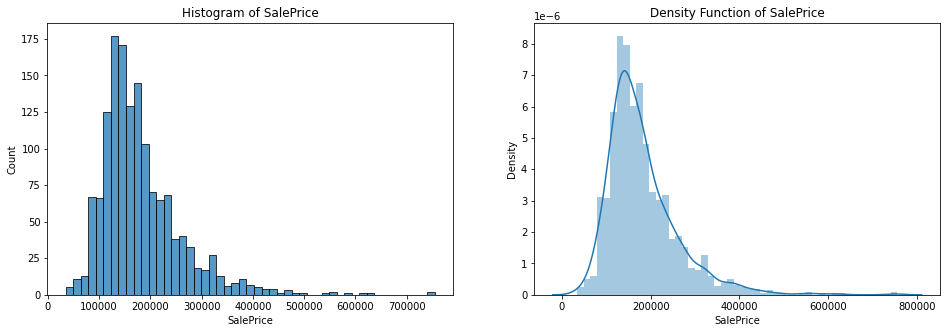

Variable     |          min |         mean |       median |          max
------------------------------------------------------------------------
SalePrice    |     34900.00 |    180921.20 |    163000.00 |    755000.00
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             |     variance |    std. dev. |     skewness |     kurtosis
------------------------------------------------------------------------
SalePrice    |     6.31e+09 |     79442.50 |        1.883 |        6.536
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
modes        : [140000]


In [5]:
fig, axs = plt.subplots(1, 2, figsize=[16,5])
sns.histplot(data=ames, x='SalePrice', ax=axs[0])
axs[0].set_title('Histogram of SalePrice')
sns.distplot(ames['SalePrice'], ax=axs[1])
axs[1].set_title('Density Function of SalePrice')
plt.show()

# Print statistical measures
print_moments(ames.SalePrice)

The values of the response variable *SalePrice* are distributed between \$34.900 and \$755.000 with one mode at \$140.000, which is lower than the median at \$163.000, which is lower than the average price of \$180.921. The distribution of *SalePrice* is asymmetric with relatively few large values and tails off to the right (positive skewness). It is also relatively peaked (positive kurtosis). 

For analysis of the relationships with other variables would be more suitable a log transformation of *SalePrice*.

In [6]:
# Add log transformed SalePrice to the dataset
ames['logSalePrice'] = ames.SalePrice.apply(np.log10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


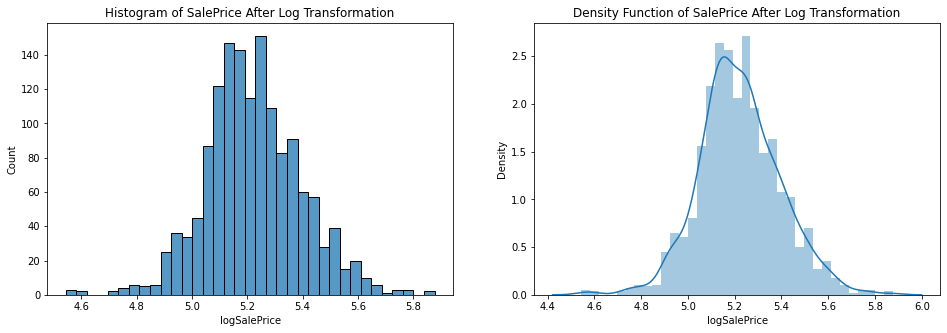

Variable     |          min |         mean |       median |          max
------------------------------------------------------------------------
logSalePrice |         4.54 |         5.22 |         5.21 |         5.88
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             |     variance |    std. dev. |     skewness |     kurtosis
------------------------------------------------------------------------
logSalePrice |     3.01e-02 |         0.17 |        0.121 |        0.810
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
modes        : [5.15]


In [7]:
fig, axs = plt.subplots(1, 2, figsize=[16,5])
sns.histplot(data=ames, x='logSalePrice', ax=axs[0])
axs[0].set_title('Histogram of SalePrice After Log Transformation')
sns.distplot(ames['logSalePrice'], ax=axs[1])
axs[1].set_title('Density Function of SalePrice After Log Transformation')
plt.show()

# Print statistical measures
print_moments(ames.logSalePrice)

The distribution of *logSalePrice* is almost symmetric with skewness close to zero although still a bit peaked.

### Univeariate Analysis of Explanatory Variables
Out of 79 independent variables, I chose 6 for further investigation. These are three continuous numeric variables (*GrLivArea*, *GarageArea*, *TotalBsmtSF*), one discrete numeric variable (*YearRemodAdd*), one ordinal categorical variable (*OverallQual*), and one nominal categorical variable (*Neighborhood*). The five-number summary of the numeric variables shows the next cell:

In [21]:
# Define variables for further investigation
var_set = ['Neighborhood', 'OverallQual', 'YearRemodAdd', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'logSalePrice', 'SalePrice']

# Show five-number summary statistics
ames.loc[:, var_set[:-2]].describe()

,YearRemodAdd,GrLivArea,GarageArea,TotalBsmtSF
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,1984.865753,1515.463699,472.980137,1057.429452
std,20.645407,525.480383,213.804841,438.705324
min,1950.000000,334.000000,0.000000,0.000000
25%,1967.000000,1129.500000,334.500000,795.750000
50%,1994.000000,1464.000000,480.000000,991.500000
75%,2004.000000,1776.750000,576.000000,1298.250000
max,2010.000000,5642.000000,1418.000000,6110.000000


Look at a distribution of *GrLivArea*

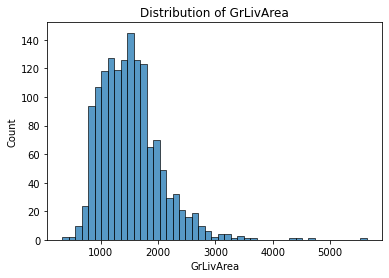

Variable     |          min |         mean |       median |          max
------------------------------------------------------------------------
GrLivArea    |       334.00 |      1515.46 |      1464.00 |      5642.00
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             |     variance |    std. dev. |     skewness |     kurtosis
------------------------------------------------------------------------
GrLivArea    |     2.76e+05 |       525.48 |        1.367 |        4.895
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
modes        : [864]


In [8]:
# Plot a distribution of GrLivArea
sns.histplot(data=ames, x='GrLivArea')
plt.title('Distribution of GrLivArea')
plt.show()

# Print statistical measures
print_moments(ames.GrLivArea)

The distribution of *GrLivArea* is asymmetrical with right (positive) skewness and peakness (positive kurtosis). There seem to be outlier with *GrLiveArea* greater than 4000 square feet:

In [9]:
# Show outliers
ames.query('GrLivArea > 4000')[var_set]

,Neighborhood,OverallQual,YearRemodAdd,GrLivArea,GarageArea,TotalBsmtSF,logSalePrice,SalePrice
Id,,,,,,,,
524,Edwards,None,2008,4676,884,3138,5.266584,184750
692,NoRidge,None,1995,4316,832,2444,5.877947,755000
1183,NoRidge,None,1996,4476,813,2396,5.872156,745000
1299,Edwards,None,2008,5642,1418,6110,5.204120,160000


Next, see the histogram of *GarageArea*:

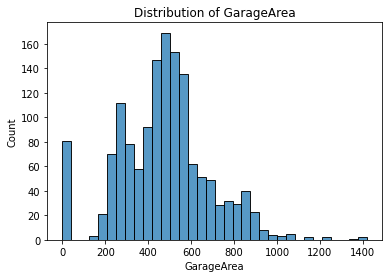

Variable     |          min |         mean |       median |          max
------------------------------------------------------------------------
GarageArea   |         0.00 |       472.98 |       480.00 |      1418.00
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             |     variance |    std. dev. |     skewness |     kurtosis
------------------------------------------------------------------------
GarageArea   |     4.57e+04 |       213.80 |        0.180 |        0.917
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
modes        : [0]


In [10]:
# Plot a distribution of GarageArea
sns.histplot(data=ames, x='GarageArea')
plt.title('Distribution of GarageArea')
plt.show()

# Print statistical measures
print_moments(ames.GarageArea)

Most frequently houses do not have any garage, as the mode of distribution is zero. The distribution of values is almost normal, i.e. has low skewness as well as kurtosis.

Next, see the histogram of *TotalBsmtSF*:

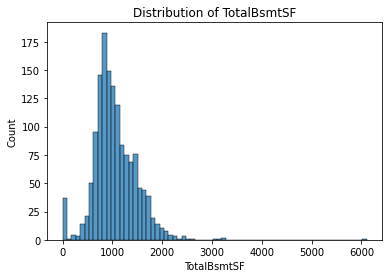

Variable     |          min |         mean |       median |          max
------------------------------------------------------------------------
TotalBsmtSF  |         0.00 |      1057.43 |       991.50 |      6110.00
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             |     variance |    std. dev. |     skewness |     kurtosis
------------------------------------------------------------------------
TotalBsmtSF  |     1.92e+05 |       438.71 |        1.524 |       13.250
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
modes        : [0]


In [11]:
# Plot a distribution of TotalBsmtSF
sns.histplot(data=ames, x='TotalBsmtSF')
plt.title('Distribution of TotalBsmtSF')
plt.show()

# Print statistical measures
print_moments(ames.TotalBsmtSF)

Again, we have a distrbution higly skewed to the right and peaked. Let's see outliers with *TotalBsmtSF* greater then 3000 squere feet:

In [22]:
ames.query('TotalBsmtSF > 3000')[var_set]

,Neighborhood,OverallQual,YearRemodAdd,GrLivArea,GarageArea,TotalBsmtSF,logSalePrice,SalePrice
Id,,,,,,,,
333,NridgHt,8,2004,1629,880,3206,5.453318,284000
441,NridgHt,None,2008,2402,672,3094,5.744293,555000
497,NoRidge,8,1993,3228,546,3200,5.633468,430000
524,Edwards,None,2008,4676,884,3138,5.266584,184750
1299,Edwards,None,2008,5642,1418,6110,5.204120,160000


Two of these houses (524 and 1299) showed up as outliers also in *GrLivArea*'s distribution.

Next, see a distribution of *YearRemodAdd*:

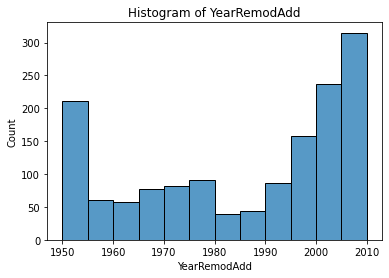

Variable     |          min |         mean |       median |          max
------------------------------------------------------------------------
YearRemodAdd |      1950.00 |      1984.87 |      1994.00 |      2010.00
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
             |     variance |    std. dev. |     skewness |     kurtosis
------------------------------------------------------------------------
YearRemodAdd |     4.26e+02 |        20.65 |       -0.504 |       -1.272
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
modes        : [1950]


In [13]:
# Plot a distribution of YearRemodAdd
sns.histplot(data=ames, x='YearRemodAdd')
plt.title('Histogram of YearRemodAdd')
plt.show()

# Print statistical measures
print_moments(ames.YearRemodAdd)

The mode of the distibution is 1950 which is also a minimum of values. This is probably a result of data gathering. The city was founded in 1864 and should have older homes on sale as well. Interestingly, the histogram shows first mode for interval 2005 to 2010 rather then 1950 to 1955. As *YearRemodAdd* is a discrete variable, let's look at value counts:

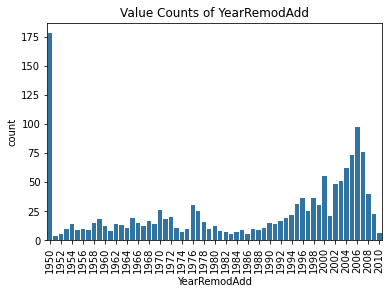

In [14]:
# Set the base color
base_color = sns.color_palette()[0]

# Plot value counts of YearRemodAdd
sns.countplot(data=ames, x='YearRemodAdd', color=base_color)

# Use every other tick label
locs, labels = plt.xticks() 
plt.xticks(locs[::2], labels[::2], rotation=90)

plt.title('Value Counts of YearRemodAdd')
plt.show()

The countplot proves the mode in 1950. The second mode is in 2006 when a lot of remodeling or additions took place. In general, the distribution of *YearRemodAdd* is a bit skewed to the left (negative skewness) and quite flat (negative kurtosis).

Next, see bar chart of *OverallQual* counts:

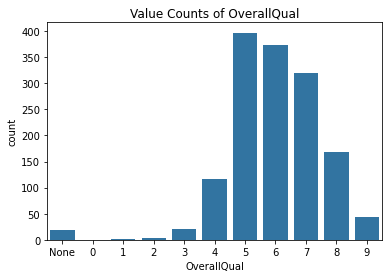

In [15]:
# Plot value counts of OverallQual
sns.countplot(data=ames, x='OverallQual', color=base_color)
plt.title('Value Counts of OverallQual')
plt.show()

The most frequent value of *OverallQual* is 5 which stands for 'Average' rate. There are a couple of missing values (None).

Finally, see the frequencies of our nominal categorical variable *Neighborhood*:

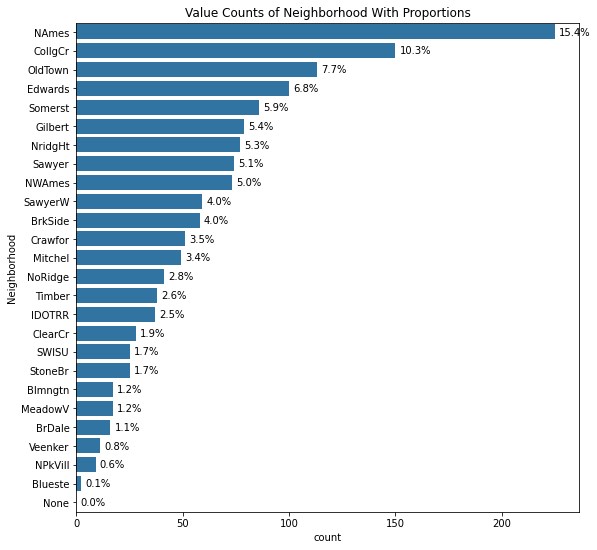

In [16]:
# Calculate values of Neighborhood
ngb_counts = ames.Neighborhood.value_counts()
n_ngb = ngb_counts.sum()

# Plot value counts of Neighborhood
plt.figure(figsize=(9,9))
sns.countplot(data=ames, y='Neighborhood', color=base_color, order=ngb_counts.index)

# Get the current tick locations and labels
locs, labels = plt.yticks() 

# Loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # Get the text property for the label to get the correct count
    count = int(ngb_counts[label.get_text()])
    pct_string = '{:0.1f}%'.format(100*count/n_ngb)

    # Print the annotation just below the top of the bar
    plt.text(count+2, loc, pct_string, ha = 'left', va='center', color = 'black')

plt.title('Value Counts of Neighborhood With Proportions')
plt.show()

The most frequent are houses from North Ames (NAmes, 15 %) followed by houses from College Creek (CollgCr, 10 %) and Old Town (OldTownm, 8 %). We do not know geographical locations of these neighborhoods so we cannot  evalute any kind of geographical model with this variable.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

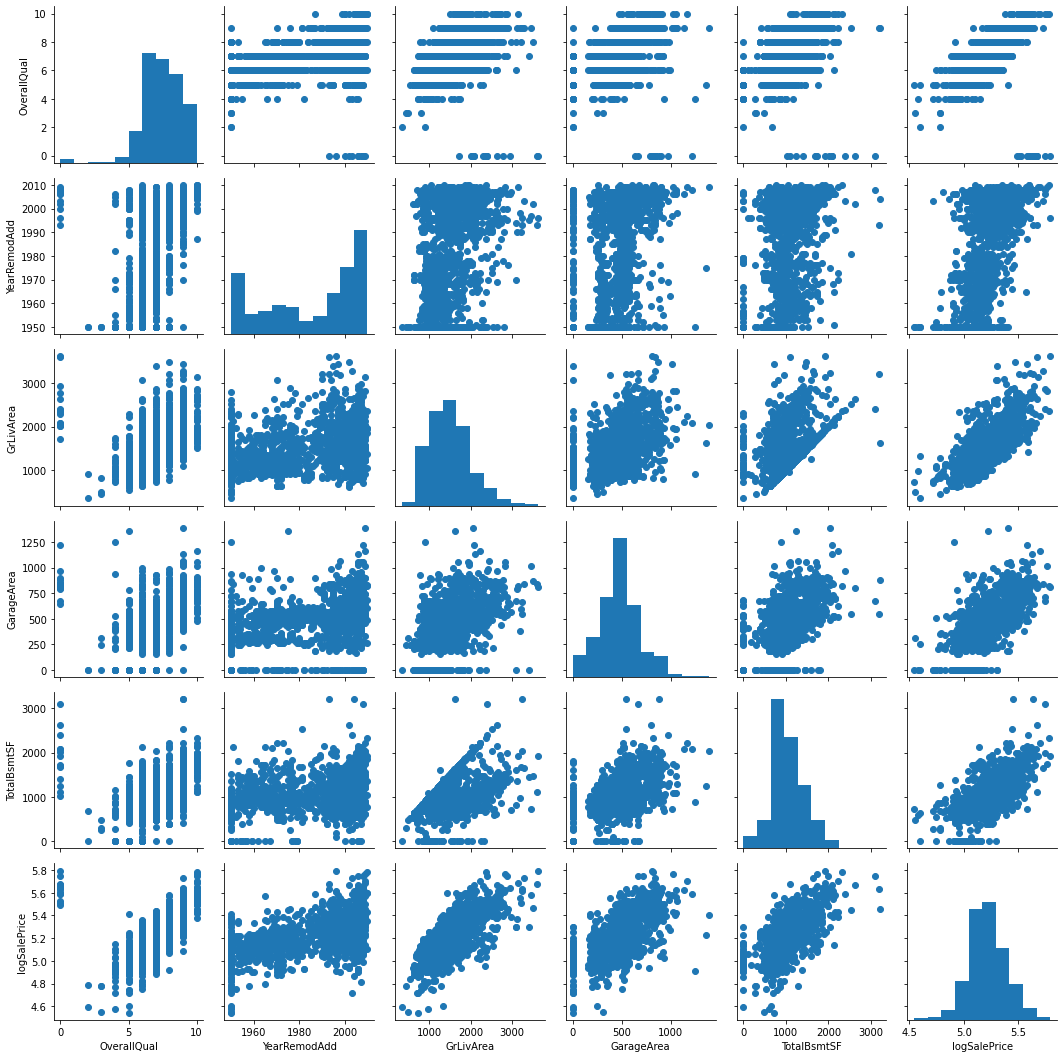

In [17]:
# PairGrid
g = sns.PairGrid(data=label_encode(ames.query('GrLivArea < 4000')), vars=var_set[1:-1])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.show()

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

